# Process 2019 legislative journal entries

In [8]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
from bs4 import BeautifulSoup as bs
import pandas as pd


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [10]:
c_text = pd.read_csv('OJ_data/2019/c_texts_2019.csv', index_col=0)
l_text = pd.read_csv('OJ_data/2019/legislation_text_2019.csv', index_col=0)

In [11]:
# Extract text from xml
l_text['texts'] = l_text['1'].apply(lambda x : bs(x, 'xml').text)

In [12]:
l_text.to_csv('data/legislation_text_2019.csv')

In [13]:
l_text.head()

,0,1,texts
0,"html PUBLIC ""-//W3C//DTD XHTML//EN"" ""xhtml-str...","<html xmlns=""http://www.w3.org/1999/xhtml""><!-...",\n\n\nOfficial Journal L 1/2019\n\n\n\n\n\n\n\...
1,"html PUBLIC ""-//W3C//DTD XHTML//EN"" ""xhtml-str...","<html xmlns=""http://www.w3.org/1999/xhtml""><!-...",\n\n\nOfficial Journal L 2/2019\n\n\n\n\n\n\n\...
2,"html PUBLIC ""-//W3C//DTD XHTML//EN"" ""xhtml-str...","<html xmlns=""http://www.w3.org/1999/xhtml""><!-...",\n\n\nOfficial Journal L 3/2019\n\n\n\n\n\n\n\...
3,"html PUBLIC ""-//W3C//DTD XHTML//EN"" ""xhtml-str...","<html xmlns=""http://www.w3.org/1999/xhtml""><!-...",\n\n\nOfficial Journal L 4/2019\n\n\n\n\n\n\n\...
4,"html PUBLIC ""-//W3C//DTD XHTML//EN"" ""xhtml-str...","<html xmlns=""http://www.w3.org/1999/xhtml""><!-...",\n\n\nOfficial Journal L 5/2019\n\n\n\n\n\n\n\...


In [14]:
data = list(l_text.texts)

In [15]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/lars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data clean

In [16]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [17]:
# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

## Tokenize

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        gensim.parsing.preprocessing.strip_non_alphanum
        yield(gensim.utils.simple_preprocess(gensim.parsing.preprocessing.strip_non_alphanum(str(sentence)).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['official', 'journal', 'issn', 'official', 'journal', 'of', 'the', 'european', 'union', 'english', 'edition', 'legislation', 'volume', 'january', 'contents', 'ii', 'non', 'legislative', 'acts', 'page', 'decisions', 'council', 'decision', 'eu', 'of', 'december', 'on', 'the', 'position', 'to', 'be', 'taken', 'on', 'behalf', 'of', 'the', 'european', 'union', 'within', 'the', 'regional', 'steering', 'committee', 'of', 'the', 'transport', 'community', 'as', 'regards', 'certain', 'budgetary', 'matters', 'in', 'relation', 'to', 'the', 'implementation', 'of', 'the', 'treaty', 'establishing', 'the', 'transport', 'community', 'en', 'acts', 'whose', 'titles', 'are', 'printed', 'in', 'light', 'type', 'are', 'those', 'relating', 'to', 'day', 'to', 'day', 'management', 'of', 'agricultural', 'matters', 'and', 'are', 'generally', 'valid', 'for', 'limited', 'period', 'the', 'titles', 'of', 'all', 'other', 'acts', 'are', 'printed', 'in', 'bold', 'type', 'and', 'preceded', 'by', 'an', 'asterisk', 'ii',

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['official_journal', 'issn_official_journal', 'of', 'the', 'european', 'union_english_edition', 'legislation', 'volume', 'january', 'contents', 'ii', 'non', 'legislative_acts_page', 'decisions', 'council', 'decision', 'eu', 'of', 'december', 'on', 'the', 'position', 'to', 'be', 'taken', 'on', 'behalf', 'of', 'the', 'european', 'union', 'within', 'the', 'regional_steering', 'committee', 'of', 'the', 'transport', 'community', 'as', 'regards', 'certain', 'budgetary', 'matters', 'in', 'relation', 'to', 'the', 'implementation', 'of', 'the', 'treaty', 'establishing', 'the', 'transport', 'community', 'en', 'acts_whose_titles', 'are', 'printed', 'in', 'light', 'type', 'are', 'those', 'relating', 'to', 'day', 'to', 'day', 'management', 'of', 'agricultural_matters', 'and', 'are', 'generally_valid', 'for', 'limited', 'period', 'the', 'titles', 'of', 'all', 'other', 'acts', 'are', 'printed', 'in', 'bold_type', 'and', 'preceded', 'by', 'an', 'asterisk', 'ii', 'non', 'legislative_acts', 'decisions',

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 1500000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['legislation', 'volume', 'content', 'legislative_act', 'page', 'decision', 'decision', 'position', 'take', 'transport', 'community', 'regard', 'certain', 'budgetary', 'matter', 'relation', 'implementation', 'treaty', 'establish', 'transport', 'community', 'act', 'whose_title', 'print', 'light', 'type', 'relate', 'day', 'day', 'management', 'limited', 'period', 'title', 'act', 'print', 'bold_type', 'precede', 'legislative_act', 'decision', 'decision', 'position', 'take', 'transport', 'community', 'regard', 'certain', 'budgetary', 'matter', 'relation', 'implementation', 'treaty', 'establish', 'function', 'particular', 'article', 'article', 'conjunction', 'article', 'thereof', 'establish', 'sign', 'decision', 'article', 'apply', 'provisionally', 'currently', 'apply', 'provisionally', 'contract', 'party', 'namely', 'transport', 'transport', 'community', 'year', 'order', 'ensure', 'proper', 'implementation', 'appropriate', 'establish', 'position', 'take', 'union', 'behalf', 'regard', 'dec

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 1), (10, 12), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 5), (17, 3), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 5), (25, 9), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 15), (38, 1), (39, 1), (40, 1), (41, 2), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 6), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 3), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 2), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 3), (81, 5), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 3), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 4), (103, 2), (104, 1), (105, 1), (106, 12), (107, 1), (108, 4), (109, 1), (110,

In [23]:
id2word[0]

'act'

In [24]:
corpus[:1][0][:10]

[(0, 2),
 (1, 2),
 (2, 3),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 4),
 (8, 1),
 (9, 1)]

In [25]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('act', 2),
  ('adopt', 2),
  ('adoption', 3),
  ('agree', 1),
  ('agreement', 1),
  ('alter', 1),
  ('amount', 1),
  ('apply', 4),
  ('appointment', 1),
  ('appropriate', 1),
  ('article', 12),
  ('attach', 2),
  ('base', 1),
  ('become', 1),
  ('behalf', 2),
  ('bold_type', 1),
  ('budget', 5),
  ('budgetary', 3),
  ('candidate', 1),
  ('cease', 1),
  ('certain', 3),
  ('change', 1),
  ('character', 1),
  ('charge', 1),
  ('committee', 5),
  ('community', 9),
  ('conjunction', 1),
  ('content', 1),
  ('contract', 1),
  ('contribution', 2),
  ('cost', 2),
  ('country', 1),
  ('cover', 1),
  ('currently', 1),
  ('date', 1),
  ('day', 3),
  ('decide', 1),
  ('decision', 15),
  ('designation', 1),
  ('director', 1),
  ('distribution', 1),
  ('do', 2),
  ('draft', 3),
  ('effect', 1),
  ('effective', 1),
  ('ensure', 1),
  ('enter', 1),
  ('equipment', 1),
  ('essential', 1),
  ('establish', 6),
  ('expenditure', 1),
  ('figure', 1),
  ('fix', 1),
  ('follow', 1),
  ('force', 1),
  ('fu

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"animal" + 0.033*"regulation" + 0.021*"product" + 0.020*"official" + '
  '0.019*"plant" + 0.017*"consignment" + 0.015*"country" + 0.015*"control" + '
  '0.012*"article" + 0.011*"food"'),
 (1,
  '0.054*"product" + 0.023*"waste" + 0.015*"water" + 0.012*"application" + '
  '0.012*"specific" + 0.012*"environmental" + 0.009*"treatment" + '
  '0.009*"number" + 0.008*"instruction" + 0.007*"contain"'),
 (2,
  '0.021*"regulation" + 0.020*"article" + 0.020*"vessel" + 0.018*"fishing" + '
  '0.013*"member" + 0.012*"state" + 0.010*"period" + 0.010*"catch" + '
  '0.009*"apply" + 0.009*"fishery"'),
 (3,
  '0.015*"tax" + 0.012*"aid" + 0.012*"cost" + 0.012*"state" + 0.011*"income" + '
  '0.009*"measure" + 0.008*"exemption" + 0.007*"amount" + 0.007*"decision" + '
  '0.007*"case"'),
 (4,
  '0.017*"member" + 0.017*"state" + 0.016*"article" + 0.013*"energy" + '
  '0.009*"include" + 0.009*"regulation" + 0.008*"system" + 0.008*"information" '
  '+ 0.008*"provide" + 0.008*"measure"'),
 (5,
  '0.

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.069397215958546

Coherence Score:  0.47969379993670974


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.088220 -0.051350       1        1  10.508998
8     -0.060156 -0.128723       2        1   9.323358
4     -0.058080  0.018119       3        1   9.177644
16     0.159297  0.033453       4        1   7.701570
17    -0.090343  0.046818       5        1   7.120708
15    -0.013392 -0.056473       6        1   6.289617
18    -0.042242  0.296382       7        1   6.139121
10    -0.135516  0.030945       8        1   5.478644
13     0.215080 -0.003786       9        1   5.113194
14    -0.035056  0.082626      10        1   4.808078
3     -0.076512  0.106455      11        1   4.580227
2     -0.032961 -0.027134      12        1   3.751791
12     0.372804  0.048619      13        1   3.705206
0      0.053461 -0.186250      14        1   3.261425
7     -0.011940 -0.011074      15        1   3.135112
11    -0.080852  0.032561      16        1   3.093567
19    -0.051457  0.000564      17        1   2.518708
1      0.135636 -0.036290      18        1   1.560772
9     -0.064818 -0.154943      19        1   1.513634
6     -0.094732 -0.040518      20        1   1.218626, topic_info=             Term          Freq         Total Category  logprob  loglift
484       product  26918.000000  26918.000000  Default  30.0000  30.0000
37       decision  26153.000000  26153.000000  Default  29.0000  29.0000
512    regulation  58966.000000  58966.000000  Default  28.0000  28.0000
5267   disclosure  11600.000000  11600.000000  Default  27.0000  27.0000
2353      service  13439.000000  13439.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
433        number    331.926010  10227.827418  Topic20  -4.9971   0.9795
129       address    275.700669   3743.412878  Topic20  -5.1827   1.7990
367   information    337.855567  21580.455967  Topic20  -4.9794   0.2505
122        action    267.631752   3628.377489  Topic20  -5.2124   1.8005
10        article    281.041519  62541.123353  Topic20  -5.1636  -0.9976

[1660 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
7612       3  0.989779             abatement
12938      3  0.947379        absolute_value
12938      5  0.047369        absolute_value
11219      8  0.934966               abstain
6858       7  0.987494              abstract
...      ...       ...                   ...
5003      14  0.143461                  zone
5003      17  0.025062                  zone
5003      19  0.050125                  zone
17298     11  0.989219        zora_accretion
8970      19  0.994031  łaczaca_miejscowosci

[8086 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 5, 17, 18, 16, 19, 11, 14, 15, 4, 3, 13, 1, 8, 12, 20, 2, 10, 7])

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Calculating the ideal number of topics
Set the initial limit to 80

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=80, step=6)

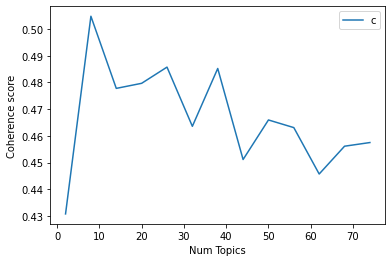

In [32]:
# Show graph
limit=80; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4308
Num Topics = 8  has Coherence Value of 0.5048
Num Topics = 14  has Coherence Value of 0.4778
Num Topics = 20  has Coherence Value of 0.4797
Num Topics = 26  has Coherence Value of 0.4858
Num Topics = 32  has Coherence Value of 0.4636
Num Topics = 38  has Coherence Value of 0.4852
Num Topics = 44  has Coherence Value of 0.4512
Num Topics = 50  has Coherence Value of 0.466
Num Topics = 56  has Coherence Value of 0.4631
Num Topics = 62  has Coherence Value of 0.4457
Num Topics = 68  has Coherence Value of 0.4561
Num Topics = 74  has Coherence Value of 0.4575


In [34]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(22,
  '0.022*"retained_earning" + 0.020*"accrual" + 0.017*"repression" + '
  '0.017*"place" + 0.017*"bear" + 0.016*"civilian_population" + '
  '0.014*"responsibility" + 0.012*"appoint" + 0.012*"regime_violent" + '
  '0.012*"development"'),
 (24,
  '0.071*"electricity" + 0.060*"network" + 0.055*"system" + 0.045*"operator" + '
  '0.039*"transmission" + 0.029*"energy" + 0.027*"regulatory" + 0.025*"market" '
  '+ 0.022*"capacity" + 0.018*"lamp"'),
 (11,
  '0.038*"service" + 0.028*"product" + 0.019*"commitment" + 0.019*"payment" + '
  '0.016*"include" + 0.013*"specific" + 0.012*"member" + 0.012*"treatment" + '
  '0.011*"limitation" + 0.010*"schedule"'),
 (0,
  '0.054*"credit" + 0.054*"tax" + 0.034*"quality_step" + 0.016*"company" + '
  '0.015*"taxable" + 0.015*"rule" + 0.012*"profit" + 0.010*"system" + '
  '0.010*"income" + 0.009*"decision"'),
 (19,
  '0.029*"article" + 0.018*"timber" + 0.014*"auction" + 0.014*"forest" + '
  '0.013*"require" + 0.013*"party" + 0.012*"compliance" + 0.011*"a

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #row = sorted(row, key=lambda x: (x[0]), reverse=True)
        topics = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #print(f"topics {topics}")
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == topics[0][0]:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                continue
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.0147,"regulation, article, datum, product, informati...",Official Journal L 1/2019 ISSN 1977-0677 Offi...
1,1,19.0,0.0223,"article, timber, auction, forest, require, par...",Official Journal L 2/2019 ISSN 1977-0677 Offi...
2,2,9.0,0.0429,"decision, regulation, implement, article, foll...",Official Journal L 3/2019 ISSN 1977-0677 Offi...
3,3,10.0,0.0628,"article, institution, follow, risk, requiremen...",Official Journal L 4/2019 ISSN 1977-0677 Offi...
4,4,15.0,0.0303,"member, article, state, authority, provide, se...",Official Journal L 5/2019 ISSN 1977-0677 Offi...
5,5,16.0,0.0327,"vehicle, type, test, approval, system, require...",Official Journal L 6/2019 ISSN 1977-0677 Offi...
6,6,5.0,0.0113,"regulation, article, datum, product, informati...",EUR-Lex - OJ:L:2019:007:FULL - EN - EUR-Lex (...
7,7,16.0,0.0471,"vehicle, type, test, approval, system, require...",Official Journal L 8/2019 ISSN 1977-0677 Offi...
8,8,18.0,0.0124,"full, disclosure, member, asset, refer, financ...",Official Journal L 8I/2019 ISSN 1977-0677 Off...
9,9,0.0,0.2690,"credit, tax, quality_step, company, taxable, r...",Official Journal L 9/2019 ISSN 1977-0677 Offi...


In [36]:
car = df_dominant_topic.loc[5]

In [37]:
car.Keywords

'vehicle, type, test, approval, system, requirement, regulation, paragraph, point, device'

In [38]:
cars = df_dominant_topic[df_dominant_topic.Dominant_Topic == 15.0]

In [39]:
cars

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
4,4,15.0,0.0303,"member, article, state, authority, provide, se...",Official Journal L 5/2019 ISSN 1977-0677 Offi...
27,27,15.0,0.1945,"member, article, state, authority, provide, se...",Official Journal L 25/2019 ISSN 1977-0677 Off...
31,31,15.0,0.0141,"member, article, state, authority, provide, se...",Official Journal L 29/2019 ISSN 1977-0677 Off...
45,45,15.0,0.1636,"member, article, state, authority, provide, se...",Official Journal L 43/2019 ISSN 1977-0677 Off...
53,53,15.0,0.0752,"member, article, state, authority, provide, se...",Official Journal L 49/2019 ISSN 1977-0677 Off...
59,59,15.0,0.1055,"member, article, state, authority, provide, se...",Official Journal L 54/2019 ISSN 1977-0677 Off...
95,95,15.0,0.1152,"member, article, state, authority, provide, se...",Official Journal L 85/2019 ISSN 1977-0677 Off...
103,103,15.0,0.0566,"member, article, state, authority, provide, se...",Official Journal L 92/2019 ISSN 1977-0677 Off...


In [41]:
df_dominant_topic.Dominant_Topic.topics = list(.unique())

SyntaxError: invalid syntax (2033129188.py, line 1)

In [ ]:
sorted(topics)

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 23.0,
 25.0,
 nan]

In [ ]:
len(df_dominant_topic[df_dominant_topic.Dominant_Topic.isnull()])

256

## Making new model

In [42]:
# Build LDA model
# Increase number of topics to 36
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=36, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/lars/Nove/Official_journal/oj/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.133679  0.067775       1        1  15.089969
8      0.132882  0.063762       2        1   8.131244
28     0.076489 -0.171815       3        1   7.175589
25     0.114916  0.001571       4        1   6.289471
29     0.020992 -0.228260       5        1   5.946353
18     0.081354  0.033346       6        1   5.668901
15     0.149766  0.057974       7        1   4.931011
10     0.144197  0.052564       8        1   4.871479
30     0.114274  0.087745       9        1   4.537040
13     0.116980 -0.071420      10        1   3.995844
17     0.115196  0.011052      11        1   3.326727
16     0.101749  0.036666      12        1   3.111735
5      0.137880 -0.016915      13        1   2.594985
21     0.116986  0.048113      14        1   2.552935
27     0.096560 -0.114513      15        1   2.292906
23     0.116979 -0.022061      16        1   2.216267
2      0.100081 -0.093283      17        1   2.054505
7      0.097362  0.007246      18        1   1.752990
20     0.115341  0.088292      19        1   1.698638
26     0.025523 -0.217328      20        1   1.453197
9      0.039156  0.059623      21        1   1.379669
19     0.077503  0.019968      22        1   1.367916
32     0.017386 -0.076135      23        1   1.268388
3      0.066797  0.069572      24        1   1.151316
12    -0.232127 -0.258482      25        1   1.047808
11     0.013414  0.091633      26        1   1.003202
35     0.022385 -0.076718      27        1   0.668566
34    -0.025324  0.066922      28        1   0.631658
22    -0.043456  0.077184      29        1   0.593921
1     -0.013585  0.067965      30        1   0.566633
33    -0.026736  0.164857      31        1   0.502705
14    -0.312602  0.052424      32        1   0.126136
0     -0.422998  0.030169      33        1   0.000075
31    -0.422999  0.030169      34        1   0.000074
6     -0.423000  0.030169      35        1   0.000074
24    -0.423000  0.030169      36        1   0.000072, topic_info=             Term          Freq         Total Category  logprob  loglift
562         state  29748.000000  29748.000000  Default  30.0000  30.0000
484       product  27921.000000  27921.000000  Default  29.0000  29.0000
512    regulation  58832.000000  58832.000000  Default  28.0000  28.0000
37       decision  26434.000000  26434.000000  Default  27.0000  27.0000
2353      service  13820.000000  13820.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2638        value      0.000066  15433.275625  Topic36 -10.6972  -5.1319
1860      network      0.000066   2979.603827  Topic36 -10.6972  -3.4872
522   requirement      0.000066  14899.449611  Topic36 -10.6972  -5.0968
2019         plan      0.000066   4315.043753  Topic36 -10.6972  -3.8576
464         point      0.000066  18342.372275  Topic36 -10.6972  -5.3047

[2740 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
2705      31  0.744195             abdollahi
3377       1  0.168129              absolute
3377       2  0.009472              absolute
3377       3  0.078144              absolute
3377       4  0.097088              absolute
...      ...       ...                   ...
5003      21  0.051980                  zone
5003      22  0.039646                  zone
5003      23  0.003524                  zone
17298     12  0.989119        zora_accretion
8970      21  0.994503  łaczaca_miejscowosci

[12888 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 29, 26, 30, 19, 16, 11, 31, 14, 18, 17, 6, 22, 28, 24, 3, 8, 21, 27, 10, 20, 33, 4, 13, 12, 36, 35, 23, 2, 34, 15, 1, 32, 7, 25])